<a href="https://colab.research.google.com/github/vyhuynh01/OCR_Project/blob/main/Scene_Text_Recognition_CRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **I. Import libraries**

In [ ]:
import os
import random
import time
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import timm
import torch
import torch.nn as nn
import torchvision
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchinfo import summary

In [ ]:
cuda_available = torch.cuda.is_available()
cuda_device_count = torch.cuda.device_count()

print(f"CUDA Available: {cuda_available}")
print(f"Number of CUDA Devices: {cuda_device_count}")

if cuda_available:
    for i in range(cuda_device_count):
        print(f"CUDA Device {i}: {torch.cuda.get_device_name(i)}")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

CUDA Available: False
Number of CUDA Devices: 0
Using device: cpu


In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)

seed = 0
set_seed(seed)

# **II. Preprocessing dataset**

In [ ]:
root_dir = 'datasets/ocr_dataset'

img_paths = []
labels = []

# Read labels from text file
with open(os.path.join(root_dir, "labels.txt"), "r") as f:
    for label in f:
        img_paths.append(label.strip().split("\t")[0])
        labels.append(label.strip().split("\t")[1])

print(f"Total images: {len(img_paths)}")

Total images: 1088


In [ ]:
letters = [char.split(".")[0].lower() for char in labels]
letters = "".join(letters)
letters = sorted(list(set(list(letters))))

# create a string of all characters in the dataset
chars = "".join(letters)

# for "blank" character
blank_char = "-"
chars += blank_char
vocab_size = len(chars)

print(f"Vocab: {chars}")
print(f"Vocab size: {vocab_size}")

Vocab: 0123456789abcdefghijklmnopqrstuvwxyz-
Vocab size: 37


In [ ]:
char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(chars))}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}
max_label_len = max([len(label) for label in labels])
max_label_len

14

# **III. Create dataloader**

In [ ]:
val_size = 0.1
test_size = 0.1
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths,
    labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle,
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle,
)

print(f"Length of X_train: {len(X_train)}")
print(f"Length of y_train: {len(y_train)}")

Length of X_train: 881
Length of y_train: 881


In [ ]:
def encode(label, char_to_idx, max_label_len):
    encoded_labels = torch.tensor(
        [char_to_idx[char] for char in label], dtype=torch.long
    )
    label_len = len(encoded_labels)
    lengths = torch.tensor(label_len, dtype=torch.long)
    padded_labels = F.pad(encoded_labels, (0, max_label_len - label_len), value=0)

    return padded_labels, lengths

In [ ]:
def decode(encoded_sequences, idx_to_char, blank_char="-"):
    decoded_sequences = []

    for seq in encoded_sequences:
        decoded_label = []
        prev_char = None  # To track the previous character

        for token in seq:
            if token != 0:  # Ignore padding (token = 0)
                char = idx_to_char[token.item()]
                # Append the character if it's not a blank or the same as the previous character
                if char != blank_char:
                    if char != prev_char or prev_char == blank_char:
                        decoded_label.append(char)
                prev_char = char  # Update previous character

        decoded_sequences.append("".join(decoded_label))

    return decoded_sequences

In [ ]:
def predict(model, img):
    model.eval()
    with torch.no_grad():
        outputs = model(img)
        print(outputs)

def decode_label(encoded_sequences, idx_to_char, blank_char="-"):
    decoded_sequences = []

    for seq in encoded_sequences:
        decoded_label = []
        for idx, token in enumerate(seq):
            if token != 0:
                char = idx_to_char[token.item()]
                if char != blank_char:
                    decoded_label.append(char)

        decoded_sequences.append("".join(decoded_label))

    return decoded_sequences

In [ ]:
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize((100, 420)),
            transforms.ColorJitter(
                brightness=0.5,
                contrast=0.5,
                saturation=0.5,
            ),
            transforms.Grayscale(
                num_output_channels=1,
            ),
            transforms.GaussianBlur(3),
            transforms.RandomAffine(
                degrees=1,
                shear=1,
            ),
            transforms.RandomPerspective(
                distortion_scale=0.3,
                p=0.5,
                interpolation=3,
            ),
            transforms.RandomRotation(degrees=2),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize((100, 420)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
}

In [ ]:
class STRDataset(Dataset):
    def __init__(
        self,
        X,
        y,
        char_to_idx,
        max_label_len,
        label_encoder=None,
        transform=None,
    ):
        self.transform = transform
        self.img_paths = X
        self.labels = y
        self.char_to_idx = char_to_idx
        self.max_label_len = max_label_len
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        if self.label_encoder:
            encoded_label, label_len = self.label_encoder(
                label, self.char_to_idx, self.max_label_len
            )
        return img, encoded_label, label_len

In [ ]:
train_dataset = STRDataset(
    X_train,
    y_train,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms["train"],
)
val_dataset = STRDataset(
    X_val,
    y_val,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms["val"],
)
test_dataset = STRDataset(
    X_test,
    y_test,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms["val"],
)

In [ ]:
print(
    f"Train dataset: {len(train_dataset)}",
    f"Val dataset: {len(val_dataset)}",
    f"Test dataset: {len(test_dataset)}",
    sep="\n",
)

Train dataset: 881
Val dataset: 109
Test dataset: 98


In [ ]:
num_cores = os.cpu_count()
print(f"Number of CPU cores: {num_cores}")

Number of CPU cores: 4


In [ ]:
train_batch_size = 64
test_batch_size = 64 * 2

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False,
)

In [ ]:
train_features, train_labels, train_lengths = next(iter(train_loader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
print(f'Labels length shape: {train_lengths.size()}')

Feature batch shape: torch.Size([64, 1, 100, 420])
Labels batch shape: torch.Size([64, 14])
Labels length shape: torch.Size([64])


In [ ]:
val_features, val_labels, val_lengths = next(iter(val_loader))
print(f'Feature batch shape: {val_features.size()}')
print(f'Labels batch shape: {val_labels.size()}')
print(f'Labels length shape: {val_lengths.size()}')

Feature batch shape: torch.Size([109, 1, 100, 420])
Labels batch shape: torch.Size([109, 14])
Labels length shape: torch.Size([109])


['enginering', 'ancient', 'constantine', 'the', 'light', 'return', 'operation', 'group', 'tan', 'u', 'in', 'peter', 'vehicle', 'aspnet', 'id', 'nightline', 'ride', 'environments', 'e', 'scotish', 'no', 'cokery', 'comunication', 'norvig', 'jeny', 'dlr', 'power', 'campbel', 'kep', 'sound', 'making', 'tickets', 'you', 'blast', 'of', 'strategy', 'inteligence', 'chapman', 'fire', 'red', 'marisa', 'date', 'to', 'system', 'is', 'these', '202', 'sanyo', 'entertaining', 'scrol', 'physical', 'private', '17', 'constantine', 'colchester', 'london', 'schol', 'moving', 'estate', 'at', 'chelmsford', 'colchester', 'sats', 'handle']


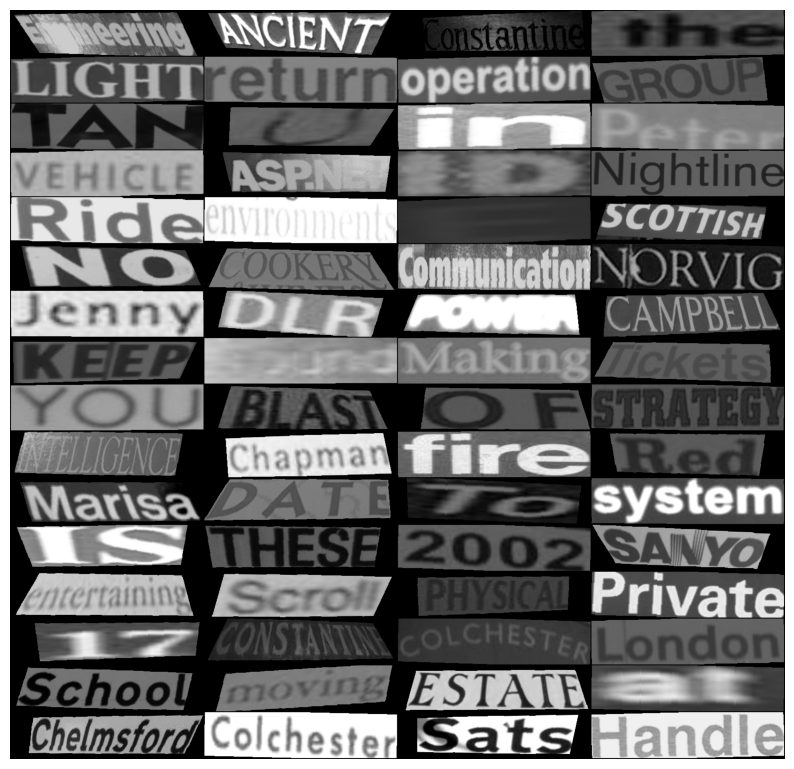

In [ ]:
# use torchvision to display a grid of images
def show_batch(imgs, labels):
    labels = decode(labels, idx_to_char)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True)
    plt.figure(figsize=(10, 20))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis("off")
    print(labels)
    plt.show()

show_batch(train_features, train_labels)

# **IV. Create model**

In [ ]:
class CRNN(nn.Module):
    def __init__(
        self, vocab_size, hidden_size, n_layers, dropout=0.2, unfreeze_layers=3
    ):
        super(CRNN, self).__init__()

        backbone = timm.create_model("resnet34", in_chans=1, pretrained=True)
        modules = list(backbone.children())[:-2]
        modules.append(nn.AdaptiveAvgPool2d((1, None)))
        self.backbone = nn.Sequential(*modules)

        # Unfreeze the last few layers
        for parameter in self.backbone[-unfreeze_layers:].parameters():
            parameter.requires_grad = True

        self.mapSeq = nn.Sequential(
            nn.Linear(512, 512), nn.ReLU(), nn.Dropout(dropout)
        )

        self.gru = nn.GRU(
            512,
            hidden_size,
            n_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0,
        )
        self.layer_norm = nn.LayerNorm(hidden_size * 2)

        self.out = nn.Sequential(
            nn.Linear(hidden_size * 2, vocab_size), nn.LogSoftmax(dim=2)
        )

    @torch.autocast(device_type="cuda")
    def forward(self, x):
        x = self.backbone(x)
        x = x.permute(0, 3, 1, 2)
        x = x.view(x.size(0), x.size(1), -1)  # Flatten the feature map
        x = self.mapSeq(x)
        x, _ = self.gru(x)
        x = self.layer_norm(x)
        x = self.out(x)
        x = x.permute(1, 0, 2)  # Based on CTC

        return x

C:\Users\chaum\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


In [ ]:
hidden_size = 256
n_layers = 3
dropout_prob = 0.2
unfreeze_layers = 3
lr = 1e-3
weight_decay = 1e-5
epochs = 100
scheduler_step_size = epochs * 0.5

model = CRNN(
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout=dropout_prob,
    unfreeze_layers=unfreeze_layers,
).to(device)
criterion = nn.CTCLoss(
    blank=char_to_idx[blank_char],
    zero_infinity=True,
    reduction="mean",
)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay,
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=scheduler_step_size, gamma=0.1
)

C:\Users\chaum\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\chaum\.cache\huggingface\hub\models--timm--resnet34.a1_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [ ]:
input_data = torch.rand((5, 1, 100, 420)).to(device)
model_summary = summary(model, input_data=input_data, verbose=0)
print(model_summary)

Layer (type:depth-idx)                        Output Shape              Param #
CRNN                                          [14, 5, 37]               --
├─Sequential: 1-1                             [5, 512, 1, 14]           --
│    └─Conv2d: 2-1                            [5, 64, 50, 210]          3,136
│    └─BatchNorm2d: 2-2                       [5, 64, 50, 210]          128
│    └─ReLU: 2-3                              [5, 64, 50, 210]          --
│    └─MaxPool2d: 2-4                         [5, 64, 25, 105]          --
│    └─Sequential: 2-5                        [5, 64, 25, 105]          --
│    │    └─BasicBlock: 3-1                   [5, 64, 25, 105]          73,984
│    │    └─BasicBlock: 3-2                   [5, 64, 25, 105]          73,984
│    │    └─BasicBlock: 3-3                   [5, 64, 25, 105]          73,984
│    └─Sequential: 2-6                        [5, 128, 13, 53]          --
│    │    └─BasicBlock: 3-4                   [5, 128, 13, 53]          230,144

In [ ]:
model.eval()

dummy_tensor = torch.rand((1, 1, 100, 420)).to(device)

with torch.no_grad():
    output = model(dummy_tensor)

print("Output shape:", output.shape)

Output shape: torch.Size([14, 1, 37])


# **V. Training model**

In [ ]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for idx, (inputs, labels, labels_len) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            outputs = model(inputs)
            logits_lens = torch.full(
                size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long
            ).to(device)

            # Print some samples after decoding
            # if idx == 0:
            #     print(decode(outputs.permute(1, 0, 2).argmax(2), idx_to_char)[:10])
            #     print(decode(labels, idx_to_char)[:10])

            loss = criterion(outputs, labels, logits_lens, labels_len)
            losses.append(loss.item())

    loss = sum(losses) / len(losses)

    return loss

In [ ]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs,
    max_grad_norm=2,
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        start = time.time()

        batch_train_losses = []

        model.train()
        for idx, (inputs, labels, labels_len) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            logits_lens = torch.full(
                size=(outputs.size(1),),
                fill_value=outputs.size(0),
                dtype=torch.long,
            ).to(device)

            loss = criterion(outputs, labels.cpu(), logits_lens.cpu(), labels_len.cpu())

            loss.backward()

            # Gradient clipping with a configurable max norm
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(
            f"EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\t\t Time: {time.time() - start:.2f} seconds"
        )

        scheduler.step()

    return train_losses, val_losses

In [ ]:
hidden_size = 256
n_layers = 3
dropout_prob = 0.2
unfreeze_layers = 3
lr = 1e-3
weight_decay = 1e-5
epochs = 100
scheduler_step_size = epochs * 0.5

model = CRNN(
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout=dropout_prob,
    unfreeze_layers=unfreeze_layers,
).to(device)
criterion = nn.CTCLoss(
    blank=char_to_idx[blank_char],
    zero_infinity=True,
    reduction="mean",
)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay,
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=scheduler_step_size, gamma=0.1
)

train_losses, val_losses = fit(
    model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs
)

save_model_path = "ocr_crnn.pt"
torch.save(model.state_dict(), save_model_path)

EPOCH 1:	Train loss: 4.8818	Val loss: 4.0283		 Time: 4.12 seconds
EPOCH 2:	Train loss: 3.7072	Val loss: 3.6601		 Time: 4.29 seconds
EPOCH 3:	Train loss: 3.4948	Val loss: 3.6020		 Time: 3.82 seconds
EPOCH 4:	Train loss: 3.4017	Val loss: 3.3988		 Time: 3.87 seconds
EPOCH 5:	Train loss: 3.3573	Val loss: 3.2892		 Time: 3.71 seconds
EPOCH 6:	Train loss: 3.2874	Val loss: 3.2864		 Time: 3.69 seconds
EPOCH 7:	Train loss: 3.0777	Val loss: 3.3925		 Time: 3.76 seconds
EPOCH 8:	Train loss: 2.8518	Val loss: 2.7633		 Time: 3.62 seconds
EPOCH 9:	Train loss: 2.6204	Val loss: 2.5133		 Time: 3.60 seconds
EPOCH 10:	Train loss: 2.2388	Val loss: 2.3389		 Time: 3.64 seconds
EPOCH 11:	Train loss: 1.9392	Val loss: 2.1583		 Time: 3.62 seconds
EPOCH 12:	Train loss: 1.7133	Val loss: 2.0122		 Time: 3.85 seconds
EPOCH 13:	Train loss: 1.4274	Val loss: 1.5082		 Time: 3.80 seconds
EPOCH 14:	Train loss: 1.1642	Val loss: 1.9339		 Time: 3.64 seconds
EPOCH 15:	Train loss: 0.9371	Val loss: 1.4892		 Time: 3.70 seconds
EPOC

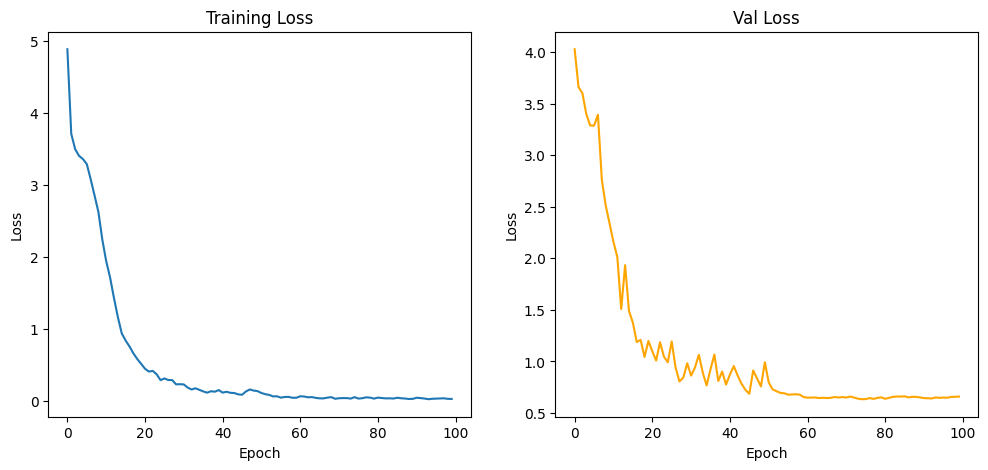

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title("Training Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[1].plot(val_losses, color="orange")
ax[1].set_title("Val Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
plt.show()

# **VI. Testing model**

In [ ]:
val_loss = evaluate(model, val_loader, criterion, device)
test_loss = evaluate(model, test_loader, criterion, device)

print("Evaluation on val/test dataset")
print("Val loss: ", val_loss)
print("Test loss: ", test_loss)

Evaluation on val/test dataset
Val loss:  0.6587507128715515
Test loss:  1.1638681888580322


In [ ]:
def predict(model, img):
    model.eval()
    with torch.no_grad():
        outputs = model(img)
        print(outputs)

def decode_label(encoded_sequences, idx_to_char, blank_char="-"):
    decoded_sequences = []

    for seq in encoded_sequences:
        decoded_label = []
        for idx, token in enumerate(seq):
            if token != 0:
                char = idx_to_char[token.item()]
                if char != blank_char:
                    decoded_label.append(char)

        decoded_sequences.append("".join(decoded_label))

    return decoded_sequences

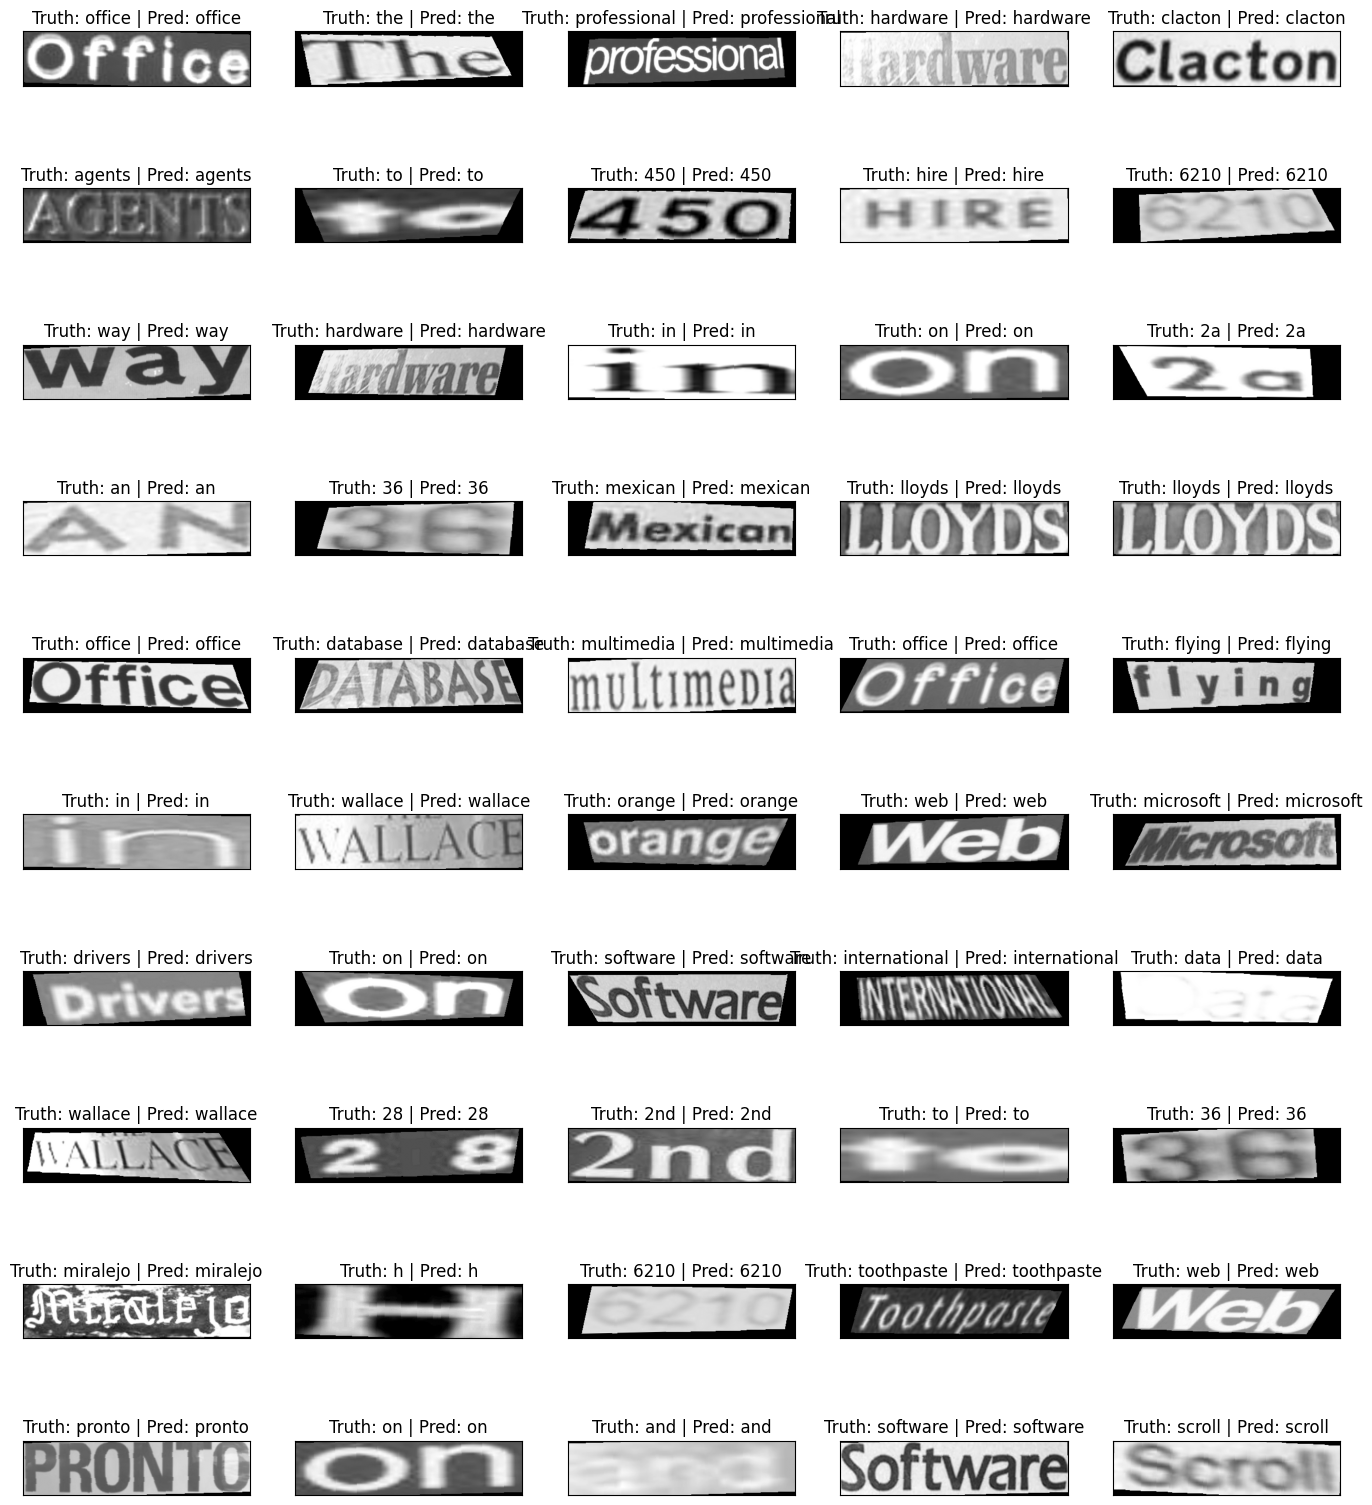

In [ ]:
# view samples
sample_result = []

for i in range(50):
    idx = np.random.randint(len(val_dataset))
    img, label, label_len = train_dataset[idx]
    img = img.to(device)
    label = label.to(device)
    label = decode_label([label], idx_to_char)[0]
    logits = model(img.unsqueeze(0))

    pred_text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)[0]

    sample_result.append((img, label, pred_text))

fig = plt.figure(figsize=(17, 20))
for i in range(50):
    ax = fig.add_subplot(10, 5, i + 1, xticks=[], yticks=[])

    img, label, pred_text = sample_result[i]
    img = img.cpu()
    title = f"Truth: {label} | Pred: {pred_text}"

    ax.imshow(img.permute(1, 2, 0), cmap="gray")
    ax.set_title(title)

plt.show()

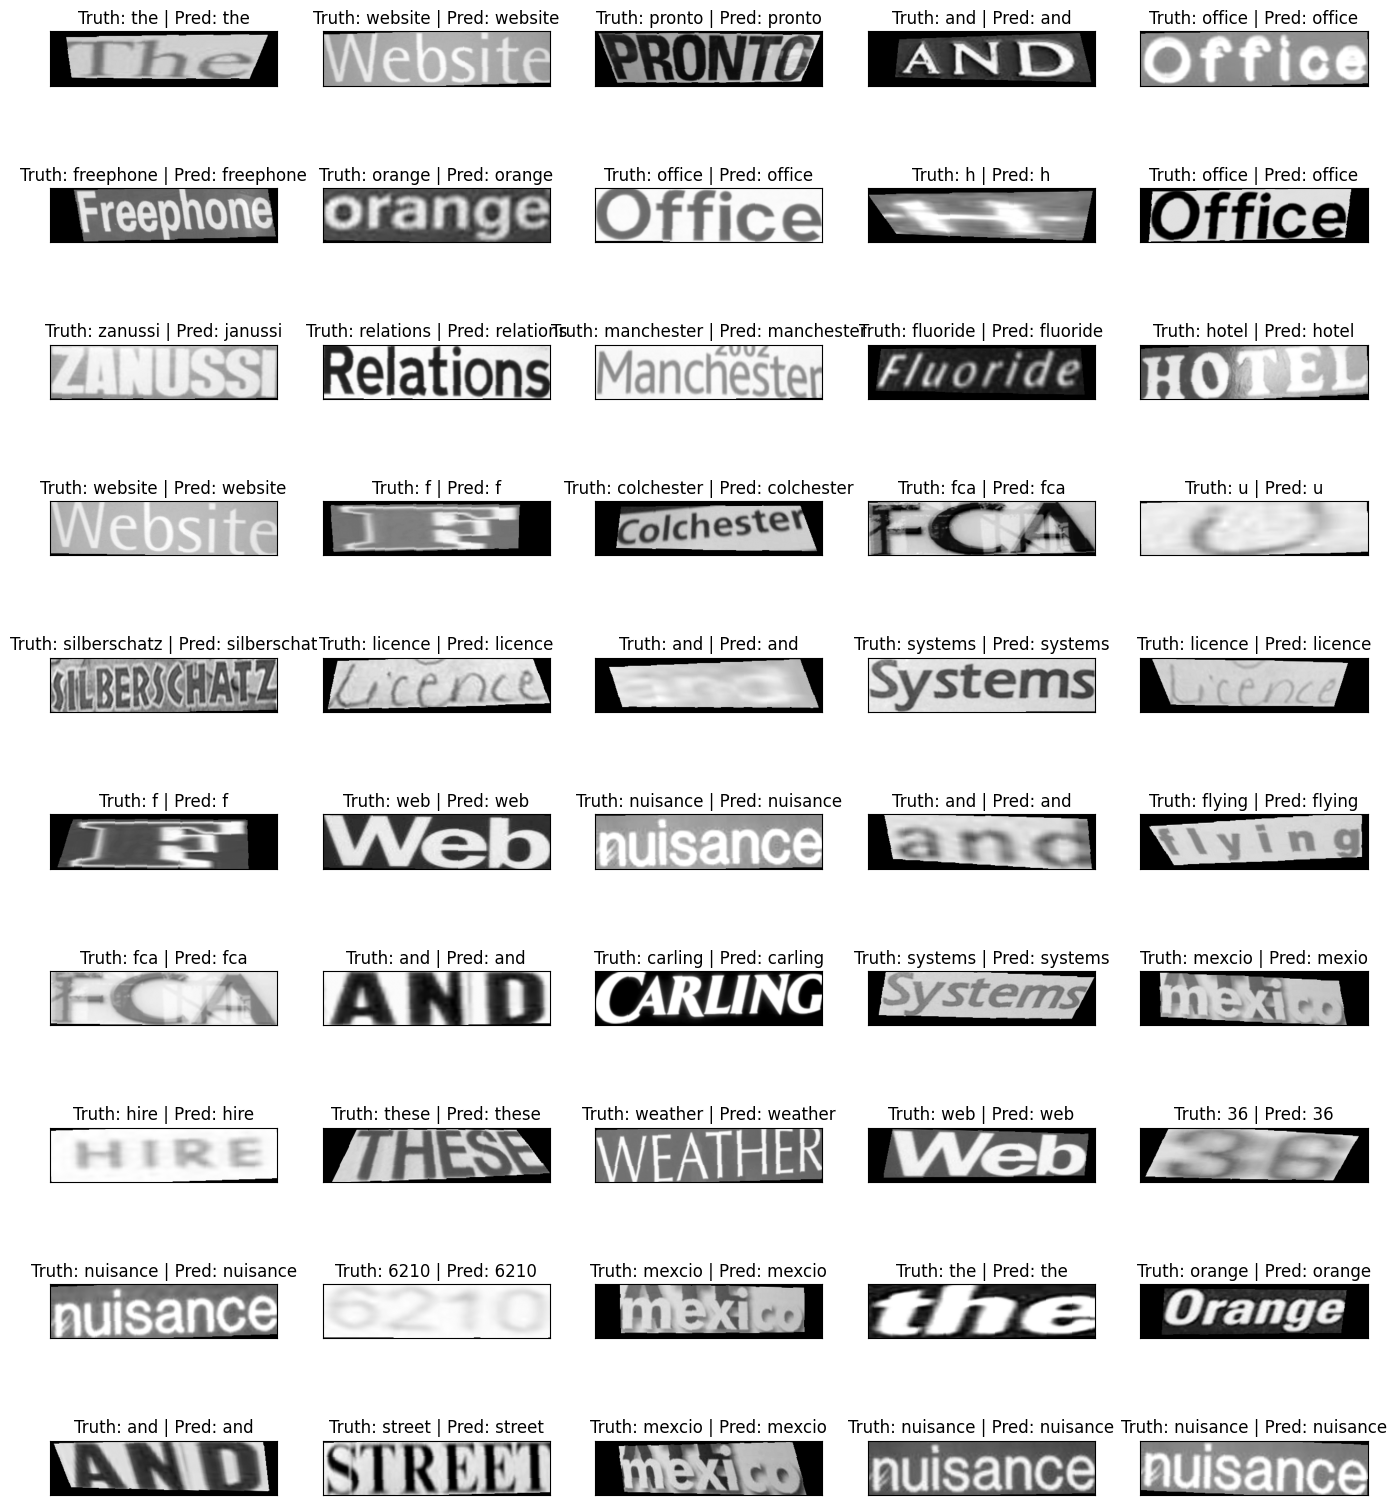

In [ ]:
# view samples
sample_result = []

for i in range(50):
    idx = np.random.randint(len(test_dataset))
    img, label, label_len = train_dataset[idx]
    img = img.to(device)
    label = label.to(device)
    label = decode_label([label], idx_to_char)[0]
    logits = model(img.unsqueeze(0))

    pred_text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)[0]

    sample_result.append((img, label, pred_text))

fig = plt.figure(figsize=(17, 20))
for i in range(50):
    ax = fig.add_subplot(10, 5, i + 1, xticks=[], yticks=[])

    img, label, pred_text = sample_result[i]
    img = img.cpu()
    title = f"Truth: {label} | Pred: {pred_text}"

    ax.imshow(img.permute(1, 2, 0), cmap="gray")
    ax.set_title(title)

plt.show()